In [1]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


Classification complete. Output saved to 'classified_reddit_posts.csv'.


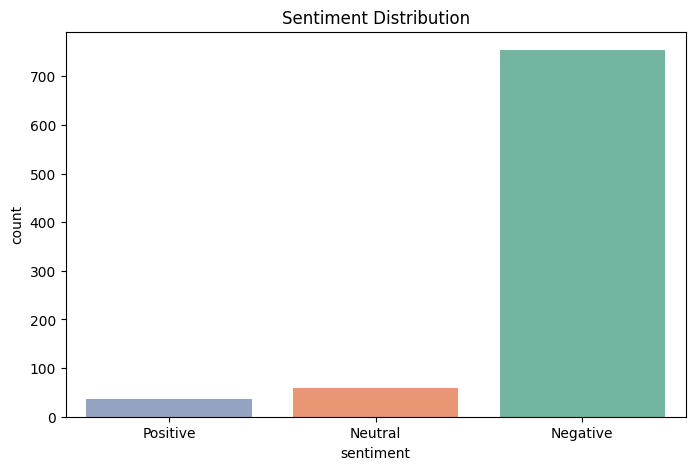

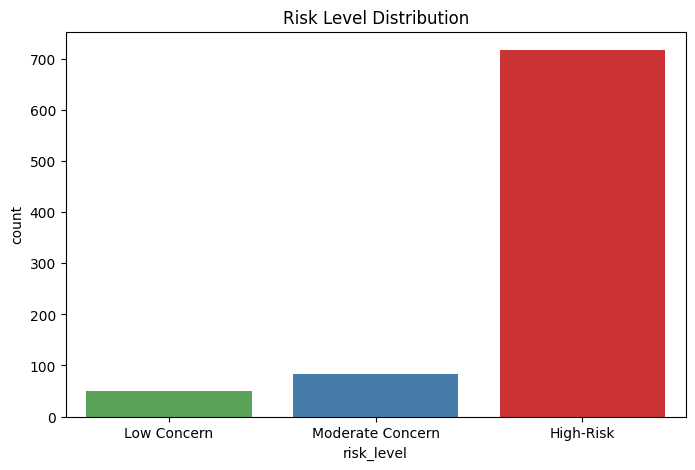

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import re

reddit_df = pd.read_csv("/content/filtered_reddit_posts.csv")

HIGH_RISK_KEYWORDS = [
    "end it", "no way out", "kill myself", "suicidal", "I can't take it", "giving up",
    "I don't want to live", "death", "dying", "die", "ending it", "can't go on", "alive"
]

MODERATE_RISK_KEYWORDS = [
    "I feel lost", "I need help", "struggling", "can't stop", "depressed", "anxious",
    "addiction", "hate", "overwhelmed", "numb", "tired of everything", "empty", "stuck"
]

NEGATION_PATTERNS = re.compile(r"\b(no|not|never|nothing|nowhere|none|nobody|isn't|can't|won't|shouldn't|doesn't|didn't)\b", re.IGNORECASE)

reddit_df["full_text"] = reddit_df["title"].fillna('') + " " + reddit_df["content"].fillna('')

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(reddit_df["full_text"])

def tfidf_risk_score(text, keywords):
    if pd.isna(text) or not isinstance(text, str):
        return 0.0

    text_index = reddit_df[reddit_df["full_text"] == text].index

    if len(text_index) == 0:
        return 0.0

    tfidf_vocab = vectorizer.vocabulary_
    score = 0

    for keyword in keywords:
        words = keyword.split()
        if len(words) == 1 and keyword in tfidf_vocab:
            idx = tfidf_vocab[keyword]
            score += tfidf_matrix[text_index[0], idx]
        elif len(words) > 1 and all(word in text.lower() for word in words):
            score += 0.5

    return score

reddit_df["tfidf_high_risk_score"] = reddit_df["full_text"].apply(lambda x: tfidf_risk_score(x, HIGH_RISK_KEYWORDS))
reddit_df["tfidf_moderate_risk_score"] = reddit_df["full_text"].apply(lambda x: tfidf_risk_score(x, MODERATE_RISK_KEYWORDS))

def classify_sentiment(text):
    if pd.isna(text) or not isinstance(text, str):
        return "Neutral"

    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    has_negation = bool(NEGATION_PATTERNS.search(text))

    if polarity > 0.2:
        return "Positive"
    elif polarity < -0.05 or has_negation:
        return "Negative"
    else:
        return "Neutral"

reddit_df["sentiment"] = reddit_df["full_text"].apply(classify_sentiment)

def classify_risk(row):
    text = row["full_text"]
    sentiment = row["sentiment"]

    if pd.isna(text) or not isinstance(text, str):
        return "Low Concern"

    text_lower = text.lower()
    if row["tfidf_high_risk_score"] > 0.5 or any(phrase in text_lower for phrase in HIGH_RISK_KEYWORDS):
        return "High-Risk"

    if row["tfidf_moderate_risk_score"] > 0.5 or any(phrase in text_lower for phrase in MODERATE_RISK_KEYWORDS):
        if sentiment == "Negative" or sentiment == "Neutral":
            return "Moderate Concern"

    return "Low Concern"


reddit_df["risk_level"] = reddit_df.apply(classify_risk, axis=1)

reddit_df.to_csv("classified_reddit_posts.csv", index=False)
print("Classification complete. Output saved to 'classified_reddit_posts.csv'.")

plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', hue='sentiment', data=reddit_df, palette='Set2', order=["Positive", "Neutral", "Negative"], legend=False)
plt.title("Sentiment Distribution")
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x='risk_level', hue='risk_level', data=reddit_df, palette='Set1', order=["Low Concern", "Moderate Concern", "High-Risk"], legend=False)
plt.title("Risk Level Distribution")
plt.show()